## Step 0: Control printer movement for testing

In [208]:
import moonrakerpy as moonpy

# Connect and home printer
print("Connecting to printer")
printer = moonpy.MoonrakerPrinter('http://192.168.8.112')
print('Moonraker connected')

print("Ensure printer is clear then press enter to start")
input()
print('Homing Printer')
printer.send_gcode('G28')
printer.send_gcode('M400')
print('Printer Homed')
print('Raising hotend')
printer.send_gcode('G1 Z50 F300')
printer.send_gcode('M400')
print('Hotend raised, please attach device to printer, then press enter')
input()
print('Lowering hotend')
printer.send_gcode('G90')
printer.send_gcode('G1 Z5 X127 Y154 F6000') # X117
printer.send_gcode('M400')
print('Hotend lowered')

Connecting to printer
Moonraker connected
Ensure printer is clear then press enter to start
Homing Printer
Printer Homed
Raising hotend
Hotend raised, please attach device to printer, then press enter
Lowering hotend
Hotend lowered


In [228]:
# Set velocity and acceleration
velocity = 50       # mm/s
acceleration = 250 # mm/s^2
repetitions = 1
max_feedrate = velocity * 60
printer.send_gcode('G90')
printer.send_gcode('SET_VELOCITY_LIMIT VELOCITY=300 ACCEL=3950')
printer.send_gcode('G1 Z2 X127 Y154 F18000') # X117
printer.send_gcode('M400')
printer.send_gcode(f'SET_VELOCITY_LIMIT VELOCITY={velocity} ACCEL={acceleration} MIN_CRUISE_RATIO=0.0')
printer.send_gcode('G91')  # Set to relative positioning
print('Ready to begin tests')
input()
print('Starting movements')
for i in range(repetitions):
    print(f'Round {i} at {velocity} mm/s, {acceleration} mm/s^2 - {repetitions} times')
    printer.send_gcode(f'G1 X-100 F{max_feedrate}')  # Move -10cm in the X axis
    printer.send_gcode('M400')  # Wait for the movement to complete
    printer.send_gcode('G4 P1000')  # Wait for 2 seconds
    printer.send_gcode(f'G1 X100 F{max_feedrate}')  # Move back +10cm in the X axis
    printer.send_gcode('M400')  # Wait for the movement to complete
    printer.send_gcode('G4 P1000')  # Wait for 2 seconds
printer.send_gcode('G90')
print('Test complete')

Ready to begin tests
Starting movements
Round 0 at 50 mm/s, 250 mm/s^2 - 1 times
Test complete


## Step 1: Preprocess and split datasets, evaluate

In [ ]:
import pandas as pd
import numpy as np
import os
print("Current working directory: ", os.getcwd())

# Create the ground truth dataset from model
time_step = 0.005 # 200Hz
distance = 100 # mm
print('Time step: ', time_step)
print('Distance: ', distance)
print('Velocity: ', velocity)
print('Acceleration: ', acceleration)
acdel_time = 0
if (distance > 2*0.5*acceleration*((velocity/acceleration)**2)):
    acdel_time = velocity/acceleration
else:
    acdel_time = np.sqrt(distance/acceleration)
print('Acceleration delay time: ', acdel_time)
acdel_distance = 0.5*acceleration*(acdel_time**2)
print('Acceleration delay distance: ', acdel_distance)
cruise_time = 0
if (distance > 2*acdel_distance):
    cruise_time = (distance - 2*acdel_distance)/velocity
print('Cruise time: ', cruise_time)
total_time = 2*acdel_time + cruise_time
print('Total time: ', total_time)
# Precalculated parameters, now synthesize data
# Time vector
gt_t = np.arange(0, total_time, time_step)
if gt_t[-1] < total_time:
    gt_t = np.append(gt_t, gt_t[-1] + time_step)
print('Total rows in GT data: ', len(gt_t))
# Phase vector (1: accel, 2: cruise, 3: decel, 4: stop)
gt_phase = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if gt_t[i] < acdel_time:
        gt_phase[i] = 1
    elif gt_t[i] < (acdel_time + cruise_time):
        gt_phase[i] = 2
    elif gt_t[i] < total_time:
        gt_phase[i] = 3
    else:
        gt_phase[i] = 4
# Acceleration vector
gt_accel = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if gt_phase[i] == 1:
        gt_accel[i] = acceleration
    elif gt_phase[i] == 2:
        gt_accel[i] = 0
    elif gt_phase[i] == 3:
        gt_accel[i] = -acceleration
    else:
        gt_accel[i] = 0
# Velocity vector
gt_velocity = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if i == 0:
        # First row is vel=0
        gt_velocity[i] = 0
    elif gt_phase[i] == 4:
        # Stop is vel=0
        gt_velocity[i] = 0
    else:
        # Calculate velocity
        gt_velocity[i] = max(0, min(velocity, gt_velocity[i-1] + gt_accel[i]*time_step))
# Position vector
gt_position = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if i == 0:
        # First row is pos=0
        gt_position[i] = 0
    elif gt_phase[i] == 4:
        # Stop is pos=total_distance
        gt_position[i] = distance
    else:
        gt_position[i] = gt_position[i-1] + gt_velocity[i]*time_step
print('GT model compute done')
# Save as csv
# gt_df = pd.DataFrame({'time': gt_t, 'phase': gt_phase, 'accel': gt_accel, 'velocity': gt_velocity, 'position': gt_position})
# gt_df.to_csv('ground_truth_master.csv', index=False)
gt_df = pd.DataFrame({'t': gt_t, 'x_x': gt_position, 'x_vx': gt_velocity})
gt_df.to_csv('ground_truth.csv', index=False)
print('GT model saved as ground_truth.csv')

# Load the device Kalman filter dataset
kalman_csv_path = '/home/luigipizzolito/Desktop/tests/linear_fast3.csv'
kalman_df = pd.read_csv(kalman_csv_path)
print('Kalman filter dataset loaded, starting preprocessing')
# Find first move time
x_pos_cols = ['x_x', 'x_y', 'x_z']
x_pos_cols_initial = kalman_df[x_pos_cols].iloc[0]
x_pos_cols_movement = (kalman_df[x_pos_cols] != x_pos_cols_initial).any(axis=1)
first_move_index = x_pos_cols_movement.idxmax() - 1
print('First move index: ', first_move_index)
# Remove first rows
kalman_df = kalman_df.loc[first_move_index:].reset_index(drop=True)
# Position offset
offset_p = kalman_df[x_pos_cols].iloc[0]
kalman_df[x_pos_cols] = kalman_df[x_pos_cols] - offset_p
# Time offset
offset_t = kalman_df['t'].iloc[0]
kalman_df['t'] = kalman_df['t'] - offset_t
# Find last move time
last_move_index = kalman_df[kalman_df['t'] >= total_time].index[0]
print('Last move index: ', last_move_index, ' @ ', kalman_df['t'].iloc[last_move_index], 's')
# Remove trailing rows
kalman_df = kalman_df.loc[:last_move_index].reset_index(drop=True)
# save as csv
kalman_df.to_csv('kalman_preprocessed_master.csv', index=False)

# Make sensor dataset
print('Creating sensor dataset')
sensor_df = kalman_df[['t', 'dt', 'quat_x', 'quat_y', 'quat_z', 'quat_w', 'accel_x', 'accel_y', 'accel_z', 'of_x', 'of_y', 'of_z']]
sensor_df.to_csv('sensor.csv', index=False)

# Split sets and interpolate, then save to CSV
print('Creating interpolated kalmandataset')







# Find the largest position vector in x_x, x_y
print("Calculating position magnitude...")
kalman_df['position_magnitude'] = np.sqrt(kalman_df['x_x']**2 + kalman_df['x_y']**2)
max_position_index = kalman_df['position_magnitude'].idxmax()
print(f"Max position index: {max_position_index}")
max_x = kalman_df.loc[max_position_index, 'x_x']
max_y = kalman_df.loc[max_position_index, 'x_y']
print(f"Max x: {max_x}, Max y: {max_y}")

# Calculate the angle relative to the z-axis
print("Calculating angle relative to z-axis...")
angle_to_z = np.arctan2(max_y, max_x)
print(f"Angle to z-axis: {angle_to_z}")

# Rotate x_x, x_y, v_vx, v_vy around the z-axis by the negative of this angle
print("Rotating coordinates around z-axis...")
cos_angle = np.cos(angle_to_z)
sin_angle = np.sin(angle_to_z)
print(f"Cosine of angle: {cos_angle}, Sine of angle: {sin_angle}")

kalman_df['x_x'] = -kalman_df['x_x'] * cos_angle - kalman_df['x_y'] * sin_angle
kalman_df['x_y'] = kalman_df['x_x'] * sin_angle + kalman_df['x_y'] * cos_angle
kalman_df['v_vx'] = -kalman_df['x_vx'] * cos_angle - kalman_df['x_vy'] * sin_angle
kalman_df['v_vy'] = kalman_df['x_vx'] * sin_angle + kalman_df['x_vy'] * cos_angle
print("Rotation complete.")

# Drop the temporary column
print("Dropping temporary column 'position_magnitude'...")
kalman_df.drop(columns=['position_magnitude'], inplace=True)
print("Temporary column dropped.")







kalman_anal_df = kalman_df[['t', 'x_x', 'x_vx']]
# interpolate to same timebase
gt_df['t'] = pd.to_numeric(gt_df['t'])
# kalman_anal_df['t'] = pd.to_numeric(kalman_anal_df['t'])
kalman_anal_df.loc[:, 't'] = pd.to_numeric(kalman_anal_df['t'])
# convert m units to mm units
for column in ['x_x', 'x_vx']:
    # kalman_anal_df[column] = kalman_anal_df[column] * -1000
    kalman_anal_df.loc[:, column] = kalman_anal_df[column] * -1000
# kalman_anal_df.loc[:, 'x_x'] = kalman_anal_df['x_x'] *2
interpolated_kalman_anal_df = pd.DataFrame()
interpolated_kalman_anal_df['t'] = gt_df['t']
for column in ['x_x', 'x_vx']:
    # interpolated_kalman_anal_df[column] = np.interp(gt_df['t'], kalman_anal_df['t'], kalman_anal_df[column])
    interpolated_kalman_anal_df.loc[:, column] = np.interp(gt_df['t'], kalman_anal_df['t'], kalman_anal_df[column])

# save
kalman_anal_df.to_csv('kalman_preprocessed.csv', index=False)
interpolated_kalman_anal_df.to_csv('kalman_interpolated.csv', index=False)

print('Visualising gt vs kalman')
# visualise
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
from sklearn.metrics import mean_squared_error
# find rsme
# kalman_anal_df.loc[:, 't'] = pd.to_numeric(kalman_anal_df['t'])
# kalman_anal_df_interpol3 = pd.DataFrame()
# kalman_anal_df_interpol3['t'] = gt_df['t']
# for column in ['x_x', 'x_vx']:
#     kalman_anal_df_interpol3.loc[:, column] = np.interp(gt_df['t'], sim_out_df['t'], kalman_anal_df[column])
    
rmse_x_x_kalman = np.sqrt(mean_squared_error(gt_df['x_x'], interpolated_kalman_anal_df['x_x']))

plt.subplot(2, 1, 1)
plt.plot(gt_df['t'], gt_df['x_x'], label=f'Ground Truth x_x (RSME:{rmse_x_x_kalman:.4f})', color='green', linestyle=':')
plt.plot(interpolated_kalman_anal_df['t'], interpolated_kalman_anal_df['x_x'], 
         label='Device x_x', color='red')
plt.title('Position: t vs x_x')
plt.xlabel('Time (s)')
plt.ylabel('x_x (mm)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gt_df['t'], gt_df['x_vx'], label='Ground Truth x_vx', color='green', linestyle=':')
plt.plot(interpolated_kalman_anal_df['t'], interpolated_kalman_anal_df['x_vx'], 
         label='Device x_vx', color='red')
plt.title('Velocity: t vs x_vx')
plt.xlabel('Time (s)')
plt.ylabel('x_vx (mm/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Current working directory:  /home/luigipizzolito/Documents/GitHub/OF_IMU-LocationCore/LSTM-TensorFlow
Time step:  0.005
Distance:  100
Velocity:  50
Acceleration:  250
Acceleration delay time:  0.2
Acceleration delay distance:  5.000000000000001
Cruise time:  1.8
Total time:  2.2
Total rows in GT data:  441
GT model compute done
GT model saved as ground_truth.csv
Kalman filter dataset loaded, starting preprocessing
First move index:  135
Last move index:  127  @  2.217081999999948 s
Creating sensor dataset
Creating interpolated kalmandataset
Calculating position magnitude...
Max position index: 123
Max x: -0.06610470000000002, Max y: -0.03227430000000009
Calculating angle relative to z-axis...
Angle to z-axis: -2.687405274254152
Rotating coordinates around z-axis...
Cosine of angle: -0.8986178477122914, Sine of angle: -0.4387322233127276
Rotation complete.
Dropping temporary column 'position_magnitude'...
Temporary column dropped.
Visualising gt vs kalman


ValueError: fp and xp are not of the same length.

<Figure size 1200x600 with 0 Axes>

## Step 3: Simulation \& Nelder-Mead Optimisation

1: Simulated with P: 0.6981596946716309, Q: 0.6936473250389099, R: 0.6981596946716309, ZUPT: 0.25 -> RMSE x_x: 119.5679963574579
2: Simulated with P: 0.7031972408294678, Q: 0.6936473250389099, R: 0.6981596946716309, ZUPT: 0.25 -> RMSE x_x: 119.73104927131422
3: Simulated with P: 0.6981596946716309, Q: 0.6941477060317993, R: 0.6981596946716309, ZUPT: 0.25 -> RMSE x_x: 119.56860990875329
4: Simulated with P: 0.6981596946716309, Q: 0.6936473250389099, R: 0.7031972408294678, ZUPT: 0.25 -> RMSE x_x: 119.39866961223149
5: Simulated with P: 0.6981596946716309, Q: 0.6936473250389099, R: 0.6981596946716309, ZUPT: 0.25 -> RMSE x_x: 119.5679963574579
6: Simulated with P: 0.6931471824645996, Q: 0.6938974857330322, R: 0.7006753087043762, ZUPT: 0.25 -> RMSE x_x: 119.31992816146101
7: Simulated with P: 0.6906503438949585, Q: 0.6939600110054016, R: 0.7013051509857178, ZUPT: 0.25 -> RMSE x_x: 119.21676574264443
8: Simulated with P: 0.6943979859352112, Q: 0.6933034658432007, R: 0.7022507786750793, ZUPT:

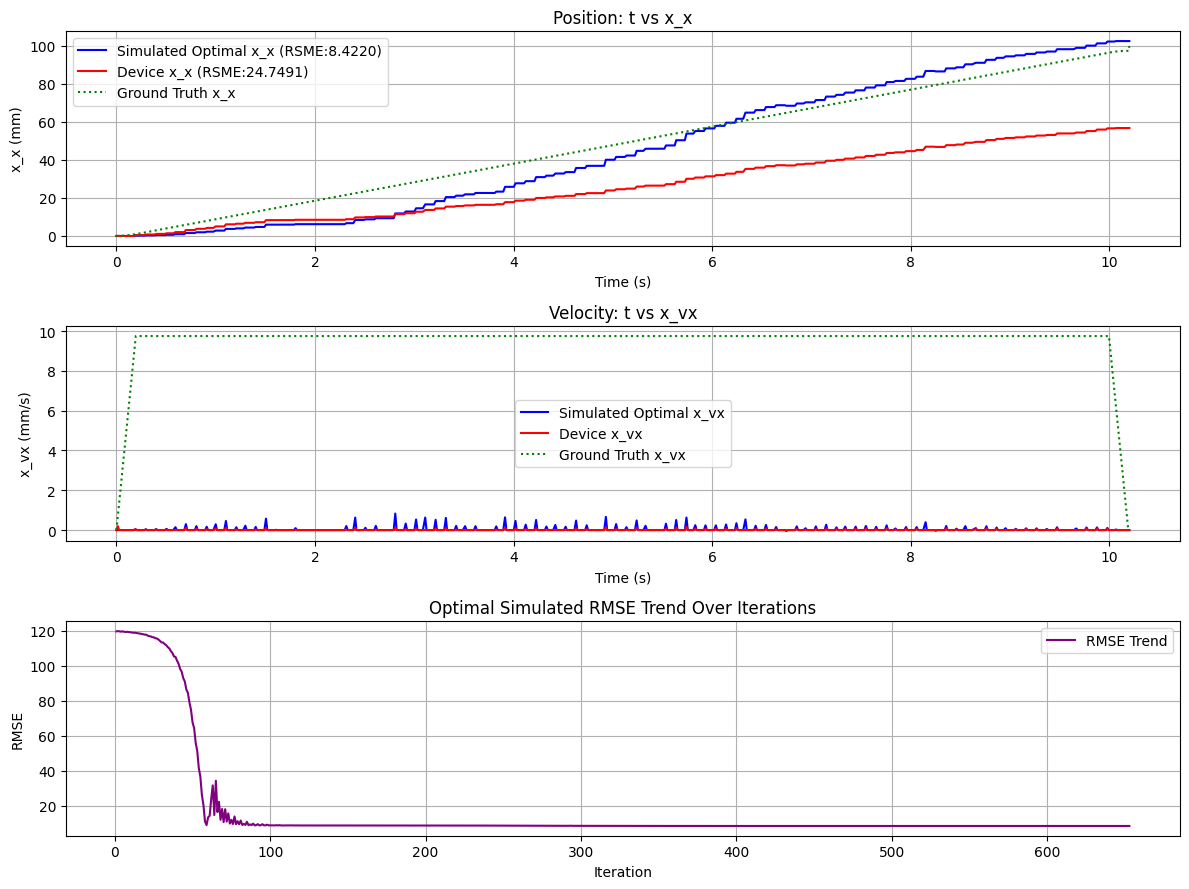

Minimum RMSE: 8.421982325471367


In [215]:

import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import pandas as pd
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
# tf.experimental.numpy.experimental_enable_numpy_behavior()

iter_cnt = 0
rmse_trend = []

# Kalman filter simulation implementation
class KalmanFilter:
    def __init__(self, KF_INIT_P, KF_INIT_Q, KF_INIT_R, ZUPT):
        self.x = np.zeros((6, 1))  # State vector
        self.P = np.eye(6) * KF_INIT_P  # State covariance matrix
        self.Q = np.eye(3) * KF_INIT_Q  # Process noise covariance matrix
        self.R = np.eye(3) * KF_INIT_R  # Measurement noise covariance matrix
        
        self.past_x = np.zeros((3, 1))
        self.ZUPT = ZUPT
        
        # State transition noise matrix
        dt = 1.0/50 # 50Hz predict
        G = np.array([[0.5*dt*dt, 0, 0],
                      [0, 0.5*dt*dt, 0],
                      [0, 0, 0.5*dt*dt],
                      [dt, 0, 0],
                      [0, dt, 0],
                      [0, 0, dt]])
        self.Qd = np.dot(G, np.dot(self.Q, G.T))
        
        # Initial and constant Jacobian matrices
        self.A = np.array([
            [0, 0, 0, 1, 0, 0],
            [0, 0, 0, 0, 1, 0],
            [0, 0, 0, 0, 0, 1],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0],
            [0, 0, 0, 0, 0, 0]
        ])
        self.C = np.array([
            [1, 0, 0, 0, 0, 0],
            [0, 1, 0, 0, 0, 0],
            [0, 0, 1, 0, 0, 0]
        ])
        
        self.f = np.zeros((6, 1))  # State transition matrix
        self.h = np.zeros((3, 1))  # Observation matrix
        
        self.K = np.zeros((3, 6))  # Kalman gain
        
    def set_initial_state(self, x):
        self.x = x
        
    def predict(self, quat, accel, dt):
        # 1. Rotate the acceleration vector to the global frame
        # 1.1 Convert the quaternion to a rotation matrix
        q0, q1, q2, q3 = quat
        R = np.array([
            [1 - 2*q2*q2 - 2*q3*q3, 2*q1*q2 - 2*q0*q3, 2*q1*q3 + 2*q0*q2],
            [2*q1*q2 + 2*q0*q3, 1 - 2*q1*q1 - 2*q3*q3, 2*q2*q3 - 2*q0*q1],
            [2*q1*q3 - 2*q0*q2, 2*q2*q3 + 2*q0*q1, 1 - 2*q1*q1 - 2*q2*q2]
        ])
        # 1.2 Rotate the acceleration vector
        accel = np.dot(R, accel)

        # ZUPT detection
        if np.linalg.norm(accel) < self.ZUPT:
            accel = np.zeros((3, 1))
            self.x[3:6] = np.zeros((3, 1))

        # print("p1: Dimensions of self.x: ", self.x.shape)

        # 2. Update the current state prediction
        # 2.1 Update f
        # self.f[0:3,0] = self.x[3:6,0] * dt + 0.5 * accel * dt * dt
        # self.f[3:6,0] = self.x[3:6,0] + accel * dt
        u = np.asarray(accel).flatten()
        self.f[0, 0] = self.x[3, 0] + 0.5 * u[0] * dt
        self.f[1, 0] = self.x[4, 0] + 0.5 * u[1] * dt
        self.f[2, 0] = self.x[5, 0] + 0.5 * u[2] * dt
        self.f[3, 0] = u[0]
        self.f[4, 0] = u[1]
        self.f[5, 0] = u[2]

        self.x = self.x + dt * self.f

        # print("p2: Dimensions of self.x: ", self.x.shape)

        # 3. Update the error covariance matrix
        # 3.1 Update A
        # 3.2 Update P
        # self.P = np.dot(self.A, np.dot(self.P, self.A.T)) + self.Qd
        self.P = self.P + dt*( np.dot(self.A, self.P) + np.dot(self.P, self.A.T) + self.Qd )
        
    def update(self, quat, of, dt):
        # 1.2 Rotate the optical flow vector to global frame
        # ! skipped as hardware already computed this for us
        
        # copy of to matrix
        y = np.zeros((3, 1))
        y[0,0] = of[0]
        y[1,0] = of[1]
        y[2,0] = of[2]
        
        # Compute Kalman gain
        self.K = self.P @ self.C.T @ np.linalg.inv(self.C @ self.P @ self.C.T + self.R)
        
        # Update the state estimate
        h = np.zeros((3, 1))
        h = self.x[:3] - self.past_x
        self.x = self.x + self.K @ (y - h)
        
        # Update the error covariance matrix
        self.P = (np.eye(6) - self.K @ self.C) @ self.P
        
        # Update past state
        # self.past_x = self.x[:3].copy()
        self.past_x[0,0] = self.x[0,0]
        self.past_x[1,0] = self.x[1,0]
        self.past_x[2,0] = self.x[2,0]
        # self.past_x = tf.identity(self.x[:3])
        
def kalman_round(KF_INIT_P, KF_INIT_Q, KF_INIT_R, ZUPT, sensor_df, save_csv=False):
    kf = KalmanFilter(KF_INIT_P, KF_INIT_Q, KF_INIT_R, ZUPT)
    sim_out = []
    
    # Iterate over sensor_df dataframe rows
    for index, row in sensor_df.iterrows():
        # Extract the values from the row
        t = row['t']
        dt = row['dt']
        quat = np.array([row['quat_x'], row['quat_y'], row['quat_z'], row['quat_w']])
        accel = np.array([row['accel_x'], row['accel_y'], row['accel_z']])
        of = np.array([row['of_x'], row['of_y'], row['of_z']])
        
        
        step = np.isnan(of).all() # True: predict, False: Update
        
        # print values
        # print(f"t: {t}, step:{step}, quat: {quat}, accel: {accel}, of: {of}")
        
        if step:
            # Call the predict function
            kf.predict(quat, accel, dt)
        else:
            # Call the update function
            kf.update(quat, of, dt)
        
        # Store the state in sim_out dataframe
        sim_out.append({'t': t, 'x_x': kf.x[0,0], 'x_vx': kf.x[3,0]})
        
    # Save the simulation output to a CSV file
    sim_out_df = pd.DataFrame(sim_out)
    # convert m units to mm units
    for column in ['x_x', 'x_vx']:
        sim_out_df.loc[:, column] = sim_out_df[column] * -1000
    if save_csv:
        sim_out_df.to_csv('kalman_simulated.csv', index=False)
    # print('Kalman simulation done')
    # return sim_out_df
    
    
    # Find the largest position vector in x_x
    # print("Calculating position magnitude...")
    sim_out_df['position_magnitude'] = np.abs(sim_out_df['x_x'])
    max_position_index = sim_out_df['position_magnitude'].idxmax()
    # print(f"Max position index: {max_position_index}")
    max_x = sim_out_df.loc[max_position_index, 'x_x']
    # print(f"Max x: {max_x}")

    # Calculate the angle relative to the z-axis
    # print("Calculating angle relative to z-axis...")
    angle_to_z = np.arctan2(0, max_x)  # Since y is not present, assume y = 0
    # print(f"Angle to z-axis: {angle_to_z}")

    # Rotate x_x and x_vx around the z-axis by the negative of this angle
    # print("Rotating coordinates around z-axis...")
    cos_angle = np.cos(angle_to_z)
    sin_angle = np.sin(angle_to_z)
    # print(f"Cosine of angle: {cos_angle}, Sine of angle: {sin_angle}")

    sim_out_df['x_x'] = sim_out_df['x_x'] * cos_angle - 0 * sin_angle  # y is assumed to be 0
    sim_out_df['x_vx'] = sim_out_df['x_vx'] * cos_angle - 0 * sin_angle  # y velocity is assumed to be 0
    # print("Rotation complete.")

    # Drop the temporary column
    # print("Dropping temporary column 'position_magnitude'...")
    sim_out_df.drop(columns=['position_magnitude'], inplace=True)
    # print("Temporary column dropped.")

    
    # find rsme
    sim_out_df['t'] = pd.to_numeric(sim_out_df['t'])
    sim_out_df_interpol = pd.DataFrame()
    sim_out_df_interpol['t'] = gt_df['t']
    for column in ['x_x', 'x_vx']:
        sim_out_df_interpol.loc[:, column] = np.interp(gt_df['t'], sim_out_df['t'], sim_out_df[column])
        
    rmse_x_x = np.sqrt(mean_squared_error(gt_df['x_x'], sim_out_df_interpol['x_x']))
    global iter_cnt
    if not save_csv:
        iter_cnt += 1
    global rmse_trend
    rmse_trend.append(rmse_x_x)
    print(f'{iter_cnt}: Simulated with P: {KF_INIT_P}, Q: {KF_INIT_Q}, R: {KF_INIT_R}, ZUPT: {ZUPT} -> RMSE x_x: {rmse_x_x}')
    return rmse_x_x
    



ZUPT_OVERRIDE = 0.25
# tf.config.run_functions_eagerly(True)

def run_sim(params_np):
    params_np = np.array(params_np, dtype=np.float32)
    # params_np = np.abs(params_np)
    p, q, r, zupt = params_np[0], params_np[1], params_np[2], params_np[3]
    if ZUPT_OVERRIDE > 0:
        zupt = ZUPT_OVERRIDE
    mrse = kalman_round(p, q, r, zupt, sensor_df)
    return np.float32(mrse)

# # @tf.function
# def tf_sim(params):
#     params = params.numpy() if isinstance(params, tf.Tensor) else params
#     KF_INIT_P, KF_INIT_Q, KF_INIT_R, ZUPT = params
#     mrse = tf.py_function(run_sim, [params], tf.float32)
#     mrse.set_shape(())
#     return mrse

def tf_sim(params):
    params = tf.math.softplus(params)
    return tf.numpy_function(run_sim, [params], tf.float32)

initial_params = tf.constant([0.01, 0.001, 0.01, 0.1], dtype=tf.float32)
results = tfp.optimizer.nelder_mead_minimize(
    tf_sim,
    initial_vertex=initial_params,
    step_sizes=[0.01, 0.001, 0.01, 0.1],
    max_iterations=450,
    func_tolerance=1e-7,
    position_tolerance=1e-7
)

p_out = tf.math.softplus(results.position)
# optimal_p = results.position[0].numpy()
# optimal_q = results.position[1].numpy()
# optimal_r = results.position[2].numpy()
# optimal_zupt = results.position[3].numpy()
optimal_p = p_out[0].numpy()
optimal_q = p_out[1].numpy()
optimal_r = p_out[2].numpy()
optimal_zupt = p_out[3].numpy()
if ZUPT_OVERRIDE > 0:
    optimal_zupt = ZUPT_OVERRIDE

print(f'Optimal parameters found: P: {optimal_p:.7f}, Q: {optimal_q:.7f}, R: {optimal_r:.7f}, ZUPT: {optimal_zupt}')
print(f'#define IMU_VAR_THR {optimal_zupt:.2f}f\n#define KF_INIT_P {optimal_p:.7f}f\n#define KF_INIT_Q {optimal_q:.7f}f\n#define KF_INIT_R {optimal_r:.7f}f')
    







rsme_x_x_opt = kalman_round(optimal_p, optimal_q, optimal_r, optimal_zupt, sensor_df, True)
sim_out_df = pd.read_csv('kalman_simulated.csv')

print('Visualising gt, sim, and kalman')

# find rsme
kalman_anal_df.loc[:, 't'] = pd.to_numeric(kalman_anal_df['t'])
kalman_anal_df_interpol2 = pd.DataFrame()
kalman_anal_df_interpol2['t'] = gt_df['t']
for column in ['x_x', 'x_vx']:
    kalman_anal_df_interpol2.loc[:, column] = np.interp(gt_df['t'], sim_out_df['t'], kalman_anal_df[column])
    
rmse_x_x_kalman = np.sqrt(mean_squared_error(gt_df['x_x'], kalman_anal_df_interpol2['x_x']))

# Create the figure for the plots
plt.figure(figsize=(12, 9))

# Plot Position: t vs x_x
plt.subplot(3, 1, 1)
plt.plot(sim_out_df['t'], sim_out_df['x_x'], label=f'Simulated Optimal x_x (RSME:{rsme_x_x_opt:.4f})', color='blue')
plt.plot(kalman_anal_df['t'], kalman_anal_df['x_x'], label=f'Device x_x (RSME:{rmse_x_x_kalman:.4f})', color='red')

# Overlay gt_df on the same plot for x_x
plt.plot(gt_df['t'], gt_df['x_x'], label='Ground Truth x_x', color='green', linestyle=':')

plt.title('Position: t vs x_x')
plt.xlabel('Time (s)')
plt.ylabel('x_x (mm)')
plt.legend()
plt.grid(True)

# Plot Velocity: t vs x_vx
plt.subplot(3, 1, 2)
plt.plot(sim_out_df['t'], sim_out_df['x_vx'], label='Simulated Optimal x_vx', color='blue')
plt.plot(kalman_anal_df['t'], kalman_anal_df['x_vx'], label='Device x_vx', color='red')

# Overlay gt_df on the same plot for x_vx
plt.plot(gt_df['t'], gt_df['x_vx'], label='Ground Truth x_vx', color='green', linestyle=':')

plt.title('Velocity: t vs x_vx')
plt.xlabel('Time (s)')
plt.ylabel('x_vx (mm/s)')
plt.legend()
plt.grid(True)

# Plot RMSE trend
plt.subplot(3, 1, 3)
plt.plot(range(1, len(rmse_trend) + 1), rmse_trend, label='RMSE Trend', color='purple')
plt.title('Optimal Simulated RMSE Trend Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid(True)

# Tight layout for better spacing
plt.tight_layout()
plt.show()

# find min RSME
min_rsme = min(rmse_trend)
print(f'Minimum RMSE: {min_rsme}')



# Load the datasets CSV

# Run Nelder-Mead optimzer

# Plot the results

## Test with optimised params

In [ ]:
import pandas as pd
import numpy as np
import os
print("Current working directory: ", os.getcwd())

# Create the ground truth dataset from model
time_step = 0.005 # 200Hz
distance = 100 # mm
print('Time step: ', time_step)
print('Distance: ', distance)
print('Velocity: ', velocity)
print('Acceleration: ', acceleration)
acdel_time = 0
if (distance > 2*0.5*acceleration*((velocity/acceleration)**2)):
    acdel_time = velocity/acceleration
else:
    acdel_time = np.sqrt(distance/acceleration)
print('Acceleration delay time: ', acdel_time)
acdel_distance = 0.5*acceleration*(acdel_time**2)
print('Acceleration delay distance: ', acdel_distance)
cruise_time = 0
if (distance > 2*acdel_distance):
    cruise_time = (distance - 2*acdel_distance)/velocity
print('Cruise time: ', cruise_time)
total_time = 2*acdel_time + cruise_time
print('Total time: ', total_time)
# Precalculated parameters, now synthesize data
# Time vector
gt_t = np.arange(0, total_time, time_step)
if gt_t[-1] < total_time:
    gt_t = np.append(gt_t, gt_t[-1] + time_step)
print('Total rows in GT data: ', len(gt_t))
# Phase vector (1: accel, 2: cruise, 3: decel, 4: stop)
gt_phase = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if gt_t[i] < acdel_time:
        gt_phase[i] = 1
    elif gt_t[i] < (acdel_time + cruise_time):
        gt_phase[i] = 2
    elif gt_t[i] < total_time:
        gt_phase[i] = 3
    else:
        gt_phase[i] = 4
# Acceleration vector
gt_accel = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if gt_phase[i] == 1:
        gt_accel[i] = acceleration
    elif gt_phase[i] == 2:
        gt_accel[i] = 0
    elif gt_phase[i] == 3:
        gt_accel[i] = -acceleration
    else:
        gt_accel[i] = 0
# Velocity vector
gt_velocity = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if i == 0:
        # First row is vel=0
        gt_velocity[i] = 0
    elif gt_phase[i] == 4:
        # Stop is vel=0
        gt_velocity[i] = 0
    else:
        # Calculate velocity
        gt_velocity[i] = max(0, min(velocity, gt_velocity[i-1] + gt_accel[i]*time_step))
# Position vector
gt_position = np.zeros(len(gt_t))
for i in range(len(gt_t)):
    if i == 0:
        # First row is pos=0
        gt_position[i] = 0
    elif gt_phase[i] == 4:
        # Stop is pos=total_distance
        gt_position[i] = distance
    else:
        gt_position[i] = gt_position[i-1] + gt_velocity[i]*time_step
print('GT model compute done')
# Save as csv
# gt_df = pd.DataFrame({'time': gt_t, 'phase': gt_phase, 'accel': gt_accel, 'velocity': gt_velocity, 'position': gt_position})
# gt_df.to_csv('ground_truth_master.csv', index=False)
gt_df = pd.DataFrame({'t': gt_t, 'x_x': gt_position, 'x_vx': gt_velocity})
gt_df.to_csv('ground_truth.csv', index=False)
print('GT model saved as ground_truth.csv')

# Load the device Kalman filter dataset
kalman_csv_path = '/home/luigipizzolito/Desktop/tests/linear_slow2.csv'
kalman_df = pd.read_csv(kalman_csv_path)
print('Kalman filter dataset loaded, starting preprocessing')
# Find first move time
x_pos_cols = ['x_x', 'x_y', 'x_z']
x_pos_cols_initial = kalman_df[x_pos_cols].iloc[0]
x_pos_cols_movement = (kalman_df[x_pos_cols] != x_pos_cols_initial).any(axis=1)
first_move_index = x_pos_cols_movement.idxmax() - 1
print('First move index: ', first_move_index)
# Remove first rows
kalman_df = kalman_df.loc[first_move_index:].reset_index(drop=True)
# Position offset
offset_p = kalman_df[x_pos_cols].iloc[0]
kalman_df[x_pos_cols] = kalman_df[x_pos_cols] - offset_p
# Time offset
offset_t = kalman_df['t'].iloc[0]
kalman_df['t'] = kalman_df['t'] - offset_t
# Find last move time
last_move_index = kalman_df[kalman_df['t'] >= total_time].index[0]
print('Last move index: ', last_move_index, ' @ ', kalman_df['t'].iloc[last_move_index], 's')
# Remove trailing rows
kalman_df = kalman_df.loc[:last_move_index].reset_index(drop=True)
# save as csv
kalman_df.to_csv('kalman_preprocessed_master.csv', index=False)

# Make sensor dataset
print('Creating sensor dataset')
sensor_df = kalman_df[['t', 'dt', 'quat_x', 'quat_y', 'quat_z', 'quat_w', 'accel_x', 'accel_y', 'accel_z', 'of_x', 'of_y', 'of_z']]
sensor_df.to_csv('sensor.csv', index=False)

# Split sets and interpolate, then save to CSV
print('Creating interpolated kalmandataset')
kalman_anal_df = kalman_df[['t', 'x_x', 'x_vx']]
# interpolate to same timebase
gt_df['t'] = pd.to_numeric(gt_df['t'])
# kalman_anal_df['t'] = pd.to_numeric(kalman_anal_df['t'])
kalman_anal_df.loc[:, 't'] = pd.to_numeric(kalman_anal_df['t'])
# convert m units to mm units
for column in ['x_x', 'x_vx']:
    # kalman_anal_df[column] = kalman_anal_df[column] * -1000
    kalman_anal_df.loc[:, column] = kalman_anal_df[column] * -1000
# kalman_anal_df.loc[:, 'x_x'] = kalman_anal_df['x_x'] *2
interpolated_kalman_anal_df = pd.DataFrame()
interpolated_kalman_anal_df['t'] = gt_df['t']
for column in ['x_x', 'x_vx']:
    # interpolated_kalman_anal_df[column] = np.interp(gt_df['t'], kalman_anal_df['t'], kalman_anal_df[column])
    interpolated_kalman_anal_df.loc[:, column] = np.interp(gt_df['t'], kalman_anal_df['t'], kalman_anal_df[column])

# save
kalman_anal_df.to_csv('kalman_preprocessed.csv', index=False)
interpolated_kalman_anal_df.to_csv('kalman_interpolated.csv', index=False)

print('Visualising gt vs kalman')
# visualise
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
from sklearn.metrics import mean_squared_error
# find rsme
kalman_anal_df.loc[:, 't'] = pd.to_numeric(kalman_anal_df['t'])
kalman_anal_df_interpol3 = pd.DataFrame()
kalman_anal_df_interpol3['t'] = gt_df['t']
for column in ['x_x', 'x_vx']:
    kalman_anal_df_interpol3.loc[:, column] = np.interp(gt_df['t'], sim_out_df['t'], kalman_anal_df[column])
    
rmse_x_x_kalman = np.sqrt(mean_squared_error(gt_df['x_x'], kalman_anal_df_interpol3['x_x']))

plt.subplot(2, 1, 1)
plt.plot(gt_df['t'], gt_df['x_x'], label=f'Ground Truth x_x (RSME:{rmse_x_x_kalman:.4f})', color='green', linestyle=':')
plt.plot(interpolated_kalman_anal_df['t'], interpolated_kalman_anal_df['x_x'], 
         label='Device x_x', color='red')
plt.title('Position: t vs x_x')
plt.xlabel('Time (s)')
plt.ylabel('x_x (mm)')
plt.legend()
plt.grid(True)

plt.subplot(2, 1, 2)
plt.plot(gt_df['t'], gt_df['x_vx'], label='Ground Truth x_vx', color='green', linestyle=':')
plt.plot(interpolated_kalman_anal_df['t'], interpolated_kalman_anal_df['x_vx'], 
         label='Device x_vx', color='red')
plt.title('Velocity: t vs x_vx')
plt.xlabel('Time (s)')
plt.ylabel('x_vx (mm/s)')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()